# Import Packages

In [1]:
import pandas as pd
import numpy as np
import random
import csv
from prettytable import PrettyTable
from pylab import *
from scipy.stats import wasserstein_distance
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cProfile
import pstats
%matplotlib inline

from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

dev = ""

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)

# Interpolating acceleration columns with average values

In [2]:
#replaces Nan values with average values
#df: data frame of data to use
def interpolation(df):
    col_to_avg = list(df.columns) #Start with keeping all the columns as columns to use an average interpolation on
    for k in range(len(list(df.columns))):
        if list(df.columns)[k].startswith(('discrete', 'label')): #Remove label and discrete columns from col_to_avg
            col_to_avg.remove(list(df.columns)[k])
    
    df_with_avg = df[col_to_avg].fillna(df[col_to_avg].mean()) #Interpolate nan columns for all continuous-valued columns with average
    
    col_to_zero = list(df.columns)
    for k in range(len(list(df.columns))):
        if not list(df.columns)[k].startswith(('discrete', 'label')): #Remove all columns except label and discrete
            col_to_zero.remove(list(df.columns)[k])
    
    df_with_zero = df[col_to_zero].fillna(0) #Interpolate nan values for label and discrete columns with 0
    
    return pd.concat([df_with_avg, df_with_zero], axis = 1)

# Load and scale data

In [3]:
##load and scale data
#returns scaled data (X) and labels (Y)
#file_name: string, file with data to be used
#label: string, activity to do
def start_data(file_name, label):
    #read csv into dataframe
    data = pd.read_csv(file_name)
    
    #seperate only acceleration data
    X = data.iloc[:,1:27]
    y = data[[label]]

    #seperate only "on" labels
    X = X[y[label] == 1]
    y = y[y[label] == 1]
    
    #interpolate averages per column
    X = interpolation(X).values
    y = interpolation(y).values
    
    #scale the data
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    X = sc.fit_transform(X)
    
    return X, y

# Generator Architecture and its Loss

In [4]:
#defines each generator layer
#input and output dimensions needed
def generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.Dropout(0.1),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace = True)
    )

#returns n_samples of z_dim (number of dimensions of latent space) noise
def get_noise(n_samples, z_dim):
    #torch.manual_seed(0)
    return 200 * torch.randn(n_samples, z_dim).to(device)

#defines generator class
class Generator(nn.Module):
    def __init__(self, z_dim = 10, feature_dim = 26, hidden_dim = 128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            generator_block(z_dim, int(hidden_dim/2)),
            generator_block(int(hidden_dim/2), int(hidden_dim/4)),
            generator_block(int(hidden_dim/4), 30),
            generator_block(30, 28),
            nn.Linear(28, feature_dim)
        )
    def forward(self, noise):
        return self.gen(noise)

##calculates generator loss
#gen: generator
#disc: discriminator
#criterion: loss function
#batch_size: batch size
#z_dim: number of dimensions in the latent space
def get_gen_loss(gen, disc, criterion, batch_size, z_dim):
    latent_vectors = get_noise(batch_size, z_dim)
    fake_features = gen(latent_vectors)
    disc.eval()
    pred = disc(fake_features)
    disc.train()
    gen_loss = criterion(pred, torch.ones_like(pred))
    return gen_loss

# Discriminator Architecture and Its Loss

In [5]:
#defines each discriminator layer
def discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.Dropout(0.1),
        nn.LeakyReLU(0.05)
    )

#defines discriminator class
class Discriminator(nn.Module):
    def __init__(self, feature_dim = 26, hidden_dim = 16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            discriminator_block(feature_dim, hidden_dim),
            discriminator_block(hidden_dim, int(hidden_dim/2)),
            discriminator_block(int(hidden_dim/2), int(hidden_dim/4)),
            nn.Linear(int(hidden_dim/4), 1),
            nn.Sigmoid()                    
        )
    def forward(self, feature_vector):
        return self.disc(feature_vector)

##calculates discriminator loss
#gen: generator
#disc: discriminator
#real_features: real (not generated) data
#batch_size: batch size
#z_dim: number of dimensions of the latent space
def get_disc_loss(gen, disc, criterion, real_features, batch_size, z_dim):
    latent_vectors = get_noise(batch_size, z_dim)
    gen.eval()
    fake_features = gen(latent_vectors)
    gen.train()
    pred_fake = disc(fake_features.detach())
    loss_fake = criterion(pred_fake, torch.zeros_like(pred_fake))
                     
    pred_real = disc(real_features)
    loss_real = criterion(pred_real, torch.ones_like(pred_real))
    
    disc_loss = (loss_fake + loss_real) / 2
    return disc_loss

# Visualize Batches

In [6]:
##prints a plot of a generator batch
#gen: generator
#b_size: batch size
#epochs: current epoch (-1)
def visualize_gen_batch(gen, b_size, epochs = -1):
    #print(str(b_size))
    latent_vectors = get_noise(b_size, z_dim)
    #print(latent_vectors.shape)
    fake_features = gen(latent_vectors)
    #print(fake_features.shape)
    
    w_img = fake_features
    wmin = torch.min(w_img)
    wmax = torch.max(w_img)
    w_img = w_img.cpu()
    w_img = w_img.detach().numpy()
    c = plt.imshow(w_img, cmap ='Reds', vmin = wmin , vmax = wmax,
                        interpolation ='nearest', origin ='upper')
    plt.colorbar(c)
    plt.title('Generated Batch at Epoch ' + str(epochs), fontweight ="bold")
    plt.show()

##prints a plot of a batch of real data
#features: real data
def visualize_real_batch(features):
    w_img = features
    wmin = torch.min(w_img)
    wmax = torch.max(w_img)
    w_img = w_img.cpu()
    w_img = w_img.detach().numpy()
    c = plt.imshow(w_img, cmap ='Reds', vmin = wmin , vmax = wmax,
                        interpolation ='nearest', origin ='upper')
    plt.colorbar(c)
    plt.title('Real Batch of Data', fontweight ="bold")
    plt.show()

# Calculate Performance Statistics

In [7]:
##calculates performance statistics for each epoch of training
#gen: generator
#disc: discriminator
#b_size: batch size
#z_dim: number of dimensions of the latent space
##returns accuracy, precision, recall, fpR, and f1 score
def performance_stats(gen, disc, b_size, z_dim, batch = None):
    tp = 0 #true positive
    fp = 0 #false positive
    tn = 0 #true negative
    fn = 0 #false negative

    with torch.no_grad():
        y_hat_fake = torch.Tensor([0])
        y_hat_real = torch.Tensor([0])
        if batch is None:
            latent_vectors = get_noise(b_size, z_dim)
            gen.eval()
            fake_features = gen(latent_vectors)
            gen.train()
            disc.eval()
            y_hat_fake = torch.round(disc(fake_features))
            disc.train()
        else:
            latent_vectors = get_noise(b_size, z_dim)
            gen.eval()
            fake_features = gen(latent_vectors)
            gen.train()
            disc.eval()
            y_hat_fake = torch.round(disc(fake_features))
            y_hat_real = torch.round(disc(batch))
            disc.train()
         
        fpR = torch.mean(y_hat_fake)
        recall = torch.mean(y_hat_real)
        class_acc = ((len(y_hat_fake) - torch.sum(y_hat_fake)) + torch.sum(y_hat_real)) / (2*b_size)
        #print(f'Classification Accuracy: {class_acc:.2f}'
        #print(f'Recall: {recall:.2f}') #What percent of the true positives were identified
        return class_acc, recall, fpR
    

# Create Density Curves

In [8]:
#create and plot density curves for mean, x, y, z acceleration
#reals: real data
#fakes: generated data
def density_curves(reals, fakes):
    plt.figure(figsize = (15, 15))
    subplot(2, 2, 1)
    sns.kdeplot(fakes.cpu().numpy()[:,0], color = 'r', shade = True, label = 'Fake Distribution').set(xlim=(-8,8),ylim=(0,1.75))
    sns.kdeplot(reals[:,0], color = 'b', shade = True, label = 'Real Distribution').set(xlim=(-8,8),ylim=(0,1.75))
    plt.xlabel('Mean Acceleration')
    plt.ylabel('Density')
    plt.legend()
    #plt.show()

    subplot(2, 2, 2)
    sns.kdeplot(fakes.cpu().numpy()[:,18], color = 'r', shade = True, label = 'Fake Distribution').set(xlim=(-8,8),ylim=(0,1.75))
    sns.kdeplot(reals[:,18], color = 'b', shade = True, label = 'Real Distribution').set(xlim=(-8,8),ylim=(0,1.75))
    plt.xlabel('Mean X-Acceleration')
    plt.ylabel('Density')
    plt.legend()
    #plt.show()

    subplot(2, 2, 3)
    sns.kdeplot(fakes.cpu().numpy()[:,19], color = 'r', shade = True, label = 'Fake Distribution').set(xlim=(-8,8),ylim=(0,1.75))
    sns.kdeplot(reals[:,19], color = 'b', shade = True, label = 'Real Distribution').set(xlim=(-8,8),ylim=(0,1.75))
    plt.xlabel('Mean Y-Acceleration')
    plt.ylabel('Density')
    plt.legend()
    #plt.show()

    subplot(2, 2, 4)
    sns.kdeplot(fakes.cpu().numpy()[:,20], color = 'r', shade = True, label = 'Fake Distribution').set(xlim=(-8,8),ylim=(0,1.75))
    sns.kdeplot(reals[:,20], color = 'b', shade = True, label = 'Real Distribution').set(xlim=(-8,8),ylim=(0,1.75))
    plt.xlabel('Mean Z-Acceleration')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Create fake samples

In [9]:
def get_fake_samples(gen, batch_size, z_dim):
    """
    Generates fake acceleration features given a batch size, latent vector dimension, and trained generator.
    
    """
    latent_vectors = get_noise(batch_size, z_dim) ### Retrieves a 2D tensor of noise
    gen.eval()
    fake_features = gen(latent_vectors)
    gen.train()
    return fake_features ### Returns a 2D tensor of fake features of size batch_size x z_dim

# Calculate Wassertein distance for each dimension

In [10]:
##calculate Waaserstein distances for each dimension
#gen: generator
#z_dim: number of dimensions of the latent space
#feature_dim: number ofd dimensions in the feature space
#sample: sample of data
def all_Wasserstein_dists(gen, z_dim, feature_dim, sample):
    latent_vectors = get_noise(len(sample), z_dim)
    gen.eval()
    fake_features = gen(latent_vectors).cpu().detach().numpy()
    gen.train()
    sample = sample.cpu().detach().numpy()
    return torch.tensor([wasserstein_distance(fake_features[:, k], sample[:, k]) for k in range(feature_dim)])

# Initialize Training Environment 

In [11]:
###initalize parameters that depend on training loop parameters
#X: acceleration data
#y: labels associated with X data (fake or real)
#z_dim: number of dimensions to the latent space
#disc_lr: discriminator learning rate
#gen_lr: generator learning rate
#DISCRIMINATOR: 1 to indicate if discriminator is training
#batch_size: batch size
#disc: initialized discrimiantor

def initialize_params(X, y, z_dim, disc_lr, gen_lr, DISCRIMINATOR, batch_size, disc):
    #initialize generator
    gen = Generator(z_dim).to(device)
    #indicate that discriminator is training
    to_train = DISCRIMINATOR
    #create training features
    train_features = torch.tensor(X)
    #create training labels
    train_labels = torch.tensor(y)
    #concatenate to create training data
    train_data = torch.utils.data.TensorDataset(train_features, train_labels)
    #create data loader for training data
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
    #initialize generator and discriminator optimizers
    opt_disc = optim.Adam(disc.parameters(), lr = disc_lr)
    opt_gen = optim.Adam(gen.parameters(), lr = gen_lr)
    
    return gen, to_train, train_features, train_labels, train_data, train_loader, opt_disc, opt_gen   

# Saving the Model

In [12]:
# Change path and name of the Generator and Discriminator accordingly
def save_model(gen, disc, model_name):
    torch.save(gen.state_dict(), f"saved_models/{model_name}_gen.param")
    torch.save(disc.state_dict(), f"saved_models/{model_name}_disc.param")

# Visualizing Generation Quality

In [13]:
#creates and prints a plot of the generated vs real data
#data: data used
#gen: generator
#z_dim: number of dimensions of the latent space
def visualize_gen(data, gen, z_dim):
    #Number of datum to visualize
    sample_size = len(data)
    reals = data[0:sample_size, :]
    fakes = get_fake_samples(gen, sample_size, z_dim).detach()
    density_curves(reals, fakes)

# Plot Metrics

In [14]:
#plot metrics based on data (csv)
def plot_metrics(data, vanilla = True):
    if vanilla:
        sns.set(style = 'whitegrid', context = 'talk', palette = 'rainbow')
    
        plt.figure(figsize = (15, 15))
        subplot(2, 2, 1)
        sns.scatterplot(x = 'Epoch', y = 'FPR', data = data).set(xlim = (0, None))
        sns.despine()
        
        subplot(2, 2, 2)
        sns.scatterplot(x = 'Epoch', y = 'Recall', data = data).set(xlim = (0, None))
        sns.despine()
        
        subplot(2, 2, 3)
        sns.regplot(x = 'Epoch', y = 'Median Wasserstein', data = data, line_kws = {'color': 'orange'}).set(xlim = (0, None))
        sns.despine()
        
        subplot(2, 2, 4)
        sns.regplot(x = 'Epoch', y = 'Mean Wasserstein', data = data, line_kws = {'color': 'orange'}).set(xlim = (0, None))
        sns.despine()
        plt.show()
    else:
        sns.set(style = 'whitegrid', context = 'talk', palette = 'rainbow')
        plt.figure(figsize = (15, 8))
        
        subplot(1, 2, 1)
        sns.regplot(x = 'Epoch', y = 'Median Wasserstein', data = data, line_kws = {'color': 'orange'}).set(xlim = (0, None))
        sns.despine()
        
        subplot(1, 2, 2)
        sns.regplot(x = 'Epoch', y = 'Mean Wasserstein', data = data, line_kws = {'color': 'orange'}).set(xlim = (0, None))
        sns.despine()
        
        plt.show()

# Training Loop

In [15]:
######Training loop to train GAN

#Parameters to specifiy: 
    #X: starting accelerometer data
    #y: starting labels for X data (fake or real)
    
#Set parameters (do not change)
    #criterion: loss function (BCE)
    #dig: number of significant digits for printing (5)
    #feature_dim: Number of dimensions of output from generator (26)
    #GENERATOR: set generator to zero for training
    #DISCRIMINATOR: set discriminator to one for training
    #train_string: starting machine to train (DISC)
    #disc: initalize discriminator
    #rel_epochs: Epochs passed since last switch (constant training) (0)
    #rows: initialization of array to save data of each epoch to CSV file ([])
    #heading: array of column headings for table (["Epoch", "Machine Training", "Discriminator Loss", 
                    #"Generator Loss", "FPR", "Recall", "Median Wasserstein", "Mean Wasserstein"])
    #table: intialize a table as a pretty table to save epoch data
    #switch_count: number of switches in dynamic training (0)
    
#Set parameters (can change):
    #z_dim: number of dimensions of latent vector (100)
    #gen_lr: generator learning rate (.001)
    #disc_lr: discriminator learning rate (.001) (shoud be equal to gen_lr)
    #batch_size: batch size (75)
    #print_batches: Show model performance per batch (False)
    #n_epochs: number of epochs to train (100)
    #constant_train_flag: (False)
        #Set to true to train based on constant # of epochs per machine 
        #Set to false to train dynamically based on machine performance
    #save_models:
        #Set to true to save loss outputs to .txt, .csv, and model parameters (.param)
        #Set to false to not record any data during training 
        
    #Constant training approach:
        #disc_epochs: Number of consecutive epochs to train discriminator before epoch threshold (5)
        #gen_epochs: Number of consecutive epochs to train generator before epoch threshold (2)
        #epoch_threshold: Epoch number to change training epoch ratio (50)
        #disc_epochs_change: New number of consecutive epochs to train discriminator after epoch threshold is exceeded (1)
        #gen_epochs_change: New number of consecutive epochs to train generator after epoch threshold is exceeded (50)
    
    #Dynamic training approach:                        
        #static_threshold: Epoch number to change from static ratio to dynamic (18)
        #static_disc_epochs: Number of consecutive epochs to train discriminator before epoch threshold (4)
        #static_gen_epochs: Number of consecutive epochs to train generator before epoch threshold (2)
        #pull_threshold: Accuracy threshold for switching machine training when the generator is no longer competitive (0.4)
        #push_threshold: Accuracy threshold for switching machine training when the discriminator is no longer competitive (0.6)
        #recall_threshold: threshold for recall to switch machine training when discriminator is training well
        #switch_flag: indicates if we should switch our training machine (False)
        
def training_loop(X, y, criterion = nn.BCELoss(), gan_id = "Demo_GAN", dig = 5, feature_dim = 26, 
                  GENERATOR = 0, DISCRIMINATOR = 1, train_string = "DISC", disc = Discriminator(), z_dim = 100, 
                  gen_lr =  0.001, disc_lr = 0.001, batch_size = 100, constant_train_flag = True, disc_epochs = 5,
                  gen_epochs = 2, epoch_threshold = 1000000, disc_epochs_change = 5, gen_epochs_change = 2, rel_epochs = 0,
                 static_threshold = 14, static_disc_epochs = 5, static_gen_epochs = 2, pull_threshold = 0.2,
                 push_threshold = 0.8, recall_threshold = 0.75, n_epochs = 100, rows = [],
                 heading = ["Epoch", "Machine Training", "Discriminator Loss", "Generator Loss", "Accuracy", "FPR", "Recall", "Median Wasserstein", "Mean Wasserstein"],
                 table = PrettyTable(), switch_flag = False, switch_count = 0, last_real_features = [], save_models = True):
    
    disc.to(device)
    #returns generator, sets discriminator training, creates training tensor, loads data, and initializes optimizers
    gen, to_train, train_features, train_labels, train_data, train_loader, opt_disc, opt_gen = initialize_params(X, y, z_dim, disc_lr, gen_lr, DISCRIMINATOR, batch_size, disc)

    #set pretty table field names
    table.field_names = heading
    
    #Print Visualization of PDF's of Latent vs. Real Distribution
    print("Latent vs. Real Distributions")
    visualize_gen(X, gen, z_dim)
    
    train_type = "Conventional"
    if not constant_train_flag:
        train_type = "Dynamic"
        
    print("Starting Training: " + train_type)
    
    gen_trained = 0
    
    last_D_loss = -1.0
    last_G_loss = -1.0
    
    print("\nTraining Discriminator, Freezing Generator")
    
    for epoch in range(n_epochs):  
        if constant_train_flag:
            if to_train == DISCRIMINATOR and rel_epochs >= disc_epochs:
                rel_epochs = 0
                to_train = GENERATOR
                train_string = "GEN"
                print("\nTraining Generator, Freezing Discriminator")

            elif to_train == GENERATOR and rel_epochs >= gen_epochs:
                rel_epochs = 0
                to_train = DISCRIMINATOR
                train_string = "DISC"
                print("\nTraining Discriminator, Freezing Generator")

            # Change epoch ratio after intial 'leveling out'
            if epoch == epoch_threshold:
                rel_epochs = 0
                to_train = GENERATOR
                train_string = "GENERATOR"

                old_ratio = gen_epochs / disc_epochs
                gen_epochs = gen_epochs_change
                disc_epochs = disc_epochs_change
                new_ratio = gen_epochs / disc_epochs
                print(f'\n\nTraining ratio of G/D switched from {old_ratio:.{dig}f} to {new_ratio:.{dig}f}\n\n')
        else:
            if epoch < static_threshold:
                if to_train == DISCRIMINATOR and rel_epochs >= static_disc_epochs:
                    rel_epochs = 0
                    to_train = GENERATOR
                    train_string = "GEN"
                    print("\nTraining Generator, Freezing Discriminator")

                elif to_train == GENERATOR and rel_epochs >= static_gen_epochs:
                    rel_epochs = 0
                    to_train = DISCRIMINATOR
                    train_string = "DISC"
                    print("\nTraining Discriminator, Freezing Generator")

            else:
                if not switch_flag:
                    print("\nSwitching to Dynamic Training")
                    print("Pushing Generator, Freezing Generator")
                    switch_flag = True
                    to_train = DISCRIMINATOR
                    train_string = "DISC"
                if to_train == DISCRIMINATOR and fpR <= pull_threshold and R >= recall_threshold:
                    to_train = GENERATOR
                    train_string = "GEN"
                    print("\nPulling Generator, Freezing Discriminator")
                    switch_count += 1
                elif to_train == GENERATOR and fpR >= push_threshold:
                    to_train = DISCRIMINATOR
                    train_string = "DISC"
                    print("\nPushing Generator, Freezing Generator")
                    switch_count += 1
        print(f'Epoch[{epoch + 1}/{n_epochs}] {train_string} ', end ='')
        for batch_idx, (real_features, _) in enumerate(train_loader):
            batch_size = len(real_features)
            #Send batch to GPU
            real_features = real_features.float().to(device)
            
            if to_train == DISCRIMINATOR:
                ### Training Discriminator
                #visualize_real_batch(real_features.float())
                opt_disc.zero_grad()
                disc_loss = get_disc_loss(gen, disc, criterion, real_features, batch_size, z_dim)
                disc_loss.backward(retain_graph = True)
                opt_disc.step()
                last_D_loss = disc_loss.item()
                
                if last_G_loss == -1.0:
                    last_G_loss = get_gen_loss(gen, disc, criterion, batch_size, z_dim)
            
            else:
                ### Training Generator
                gen_trained += 1
                
                opt_gen.zero_grad()
                gen_loss = get_gen_loss(gen, disc, criterion, batch_size, z_dim)
                gen_loss.backward()
                opt_gen.step()
                last_G_loss = gen_loss.item()
                
                if last_D_loss == -1.0:
                    last_D_loss = get_disc_loss(gen, disc, criterion, real_features, batch_size, z_dim)
                
                
        if batch_idx == (len(train_loader) - 1):
            acc, R, fpR = performance_stats(gen, disc, batch_size, z_dim, batch = real_features)
            w_dist = all_Wasserstein_dists(gen, z_dim, feature_dim, real_features)
            median_w_dist = torch.median(w_dist)
            mean_w_dist = torch.mean(w_dist)
            
            
        ### Currently doesn't print Median/Mean Wasserstein --> Change if needed
        print(f'| LossD: {last_D_loss:.{dig}f}, LossG: {last_G_loss:.{dig}f} | Acc: {acc:.{dig}f} | fpR: {fpR:.{dig}f} | R: {R:.{dig}f} | MedianW: {median_w_dist:.{dig}f} | MeanW: {mean_w_dist:.{dig}f}')
        row_to_add = [f"{epoch + 1}", train_string, f"{last_D_loss:.{dig}f}", f"{last_G_loss:.{dig}f}", f"{acc:.{dig}f}", f"{fpR:.{dig}f}", f"{R:.{dig}f}", f"{median_w_dist:.{dig}f}", f"{mean_w_dist:.{dig}f}"]
        table.add_row(row_to_add)
        rows.append(row_to_add)
            
        rel_epochs += 1
    print("\n\nTraining Session Finished")
    print(f"Encountered {switch_count} non-trivial (dynamic) training swaps")
    percent = gen_trained / n_epochs
    print(f"Trained Generator {gen_trained} out of {n_epochs} ({percent:.3f})")

    if save_models:
        f = open("model_outputs/" + gan_id + ".txt", "w")
        f.write(table.get_string())
        f.close()
        print("Model Results Sucessfully Saved to \"model_outputs/" + gan_id + ".txt\"")
        with open("model_outputs/" + gan_id + ".csv", "w") as csvfile: 
            # creating a csv writer object 
            csvwriter = csv.writer(csvfile) 
            # writing the fields 
            csvwriter.writerow(heading)
            # writing the data rows 
            csvwriter.writerows(rows)
        print("Model Results Sucessfully Saved to \"model_outputs/" + gan_id + ".csv\"")
        save_model(gen, disc, gan_id)
        print("Generator's Trained Parameters Sucessfully Saved to \"saved_models/" + gan_id + "_gen.param\"")
        print("Discriminators's Trained Parameters Sucessfully Saved to \"saved_models/" + gan_id + "_disc.param\"")
        model_output = pd.read_csv("model_outputs/" + gan_id + ".csv")
        print("All models and outputs successfully saved")
    else:
        print("Model and output not saved")
        
    print("\n Visualization of G(z) vs. Real Distribution")
    visualize_gen(X, gen, z_dim)
    
   #return model_output

# Running Demo

Loading Data
Latent vs. Real Distributions


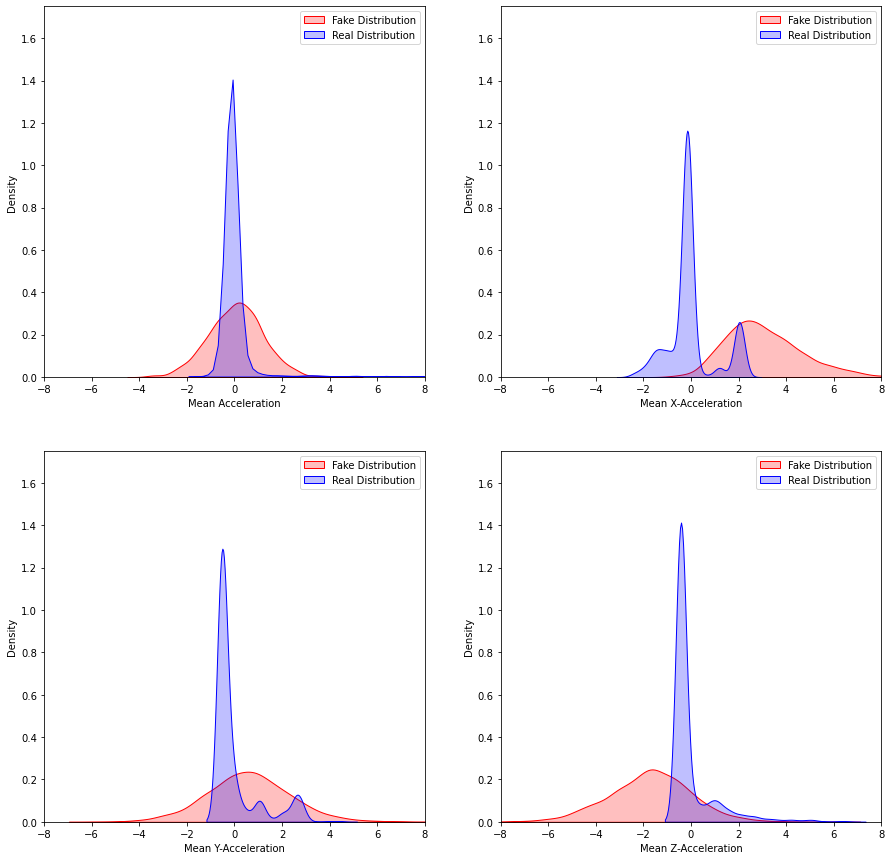

Starting Training: Dynamic

Training Discriminator, Freezing Generator
Epoch[1/200] DISC | LossD: 1.4542, LossG: 0.2078 | Acc: 0.3915 | fpR: 1.0000 | R: 0.7830 | MedianW: 0.4956 | MeanW: 0.5104
Epoch[2/200] DISC | LossD: 0.8333, LossG: 0.2078 | Acc: 0.3955 | fpR: 1.0000 | R: 0.7909 | MedianW: 0.4959 | MeanW: 0.5106
Epoch[3/200] DISC | LossD: 0.8204, LossG: 0.2078 | Acc: 0.3975 | fpR: 1.0000 | R: 0.7949 | MedianW: 0.4949 | MeanW: 0.5099
Epoch[4/200] DISC | LossD: 0.8008, LossG: 0.2078 | Acc: 0.4019 | fpR: 1.0000 | R: 0.8038 | MedianW: 0.4959 | MeanW: 0.5100
Epoch[5/200] DISC | LossD: 0.7793, LossG: 0.2078 | Acc: 0.4057 | fpR: 1.0000 | R: 0.8114 | MedianW: 0.4953 | MeanW: 0.5105

Training Generator, Freezing Discriminator
Epoch[6/200] GEN | LossD: 0.7793, LossG: 0.2482 | Acc: 0.4057 | fpR: 1.0000 | R: 0.8114 | MedianW: 0.5104 | MeanW: 0.5140
Epoch[7/200] GEN | LossD: 0.7793, LossG: 0.1510 | Acc: 0.4057 | fpR: 1.0000 | R: 0.8114 | MedianW: 0.5242 | MeanW: 0.5156

Training Discriminator, F

Epoch[66/200] DISC | LossD: 0.5997, LossG: 0.2933 | Acc: 0.7619 | fpR: 0.3782 | R: 0.9019 | MedianW: 0.5691 | MeanW: 0.5264
Epoch[67/200] DISC | LossD: 0.5957, LossG: 0.2933 | Acc: 0.8040 | fpR: 0.3005 | R: 0.9086 | MedianW: 0.5689 | MeanW: 0.5260
Epoch[68/200] DISC | LossD: 0.5956, LossG: 0.2933 | Acc: 0.8327 | fpR: 0.2499 | R: 0.9152 | MedianW: 0.5703 | MeanW: 0.5263
Epoch[69/200] DISC | LossD: 0.5908, LossG: 0.2933 | Acc: 0.8582 | fpR: 0.2046 | R: 0.9210 | MedianW: 0.5691 | MeanW: 0.5263
Epoch[70/200] DISC | LossD: 0.5828, LossG: 0.2933 | Acc: 0.8988 | fpR: 0.1309 | R: 0.9285 | MedianW: 0.5701 | MeanW: 0.5261

Pulling Generator, Freezing Discriminator
Epoch[71/200] GEN | LossD: 0.5828, LossG: 0.3225 | Acc: 0.6438 | fpR: 0.6409 | R: 0.9285 | MedianW: 0.5696 | MeanW: 0.5317
Epoch[72/200] GEN | LossD: 0.5828, LossG: 0.2731 | Acc: 0.5013 | fpR: 0.9259 | R: 0.9285 | MedianW: 0.5671 | MeanW: 0.5407

Pushing Generator, Freezing Generator
Epoch[73/200] DISC | LossD: 0.6435, LossG: 0.2731 | 

Epoch[130/200] DISC | LossD: 0.5917, LossG: 0.4763 | Acc: 0.8083 | fpR: 0.2357 | R: 0.8522 | MedianW: 0.9184 | MeanW: 0.8545
Epoch[131/200] DISC | LossD: 0.5814, LossG: 0.4763 | Acc: 0.8462 | fpR: 0.1456 | R: 0.8380 | MedianW: 0.9148 | MeanW: 0.8565

Pulling Generator, Freezing Discriminator
Epoch[132/200] GEN | LossD: 0.5814, LossG: 0.6346 | Acc: 0.7630 | fpR: 0.3120 | R: 0.8380 | MedianW: 0.9807 | MeanW: 0.9090
Epoch[133/200] GEN | LossD: 0.5814, LossG: 0.6032 | Acc: 0.6576 | fpR: 0.5229 | R: 0.8380 | MedianW: 1.0380 | MeanW: 0.9782
Epoch[134/200] GEN | LossD: 0.5814, LossG: 0.5704 | Acc: 0.5539 | fpR: 0.7301 | R: 0.8380 | MedianW: 1.1118 | MeanW: 1.0541
Epoch[135/200] GEN | LossD: 0.5814, LossG: 0.5376 | Acc: 0.4760 | fpR: 0.8859 | R: 0.8380 | MedianW: 1.1505 | MeanW: 1.1183

Pushing Generator, Freezing Generator
Epoch[136/200] DISC | LossD: 0.7064, LossG: 0.5376 | Acc: 0.5251 | fpR: 0.7692 | R: 0.8194 | MedianW: 1.1551 | MeanW: 1.1179
Epoch[137/200] DISC | LossD: 0.6763, LossG: 0.5

Epoch[196/200] GEN | LossD: 0.2990, LossG: 0.9637 | Acc: 0.8675 | fpR: 0.0169 | R: 0.7519 | MedianW: 0.8686 | MeanW: 1.3436
Epoch[197/200] GEN | LossD: 0.2990, LossG: 0.9588 | Acc: 0.8664 | fpR: 0.0191 | R: 0.7519 | MedianW: 0.8900 | MeanW: 1.3446
Epoch[198/200] GEN | LossD: 0.2990, LossG: 0.9526 | Acc: 0.8666 | fpR: 0.0186 | R: 0.7519 | MedianW: 0.9158 | MeanW: 1.3260
Epoch[199/200] GEN | LossD: 0.2990, LossG: 0.9499 | Acc: 0.8662 | fpR: 0.0195 | R: 0.7519 | MedianW: 0.9043 | MeanW: 1.3358
Epoch[200/200] GEN | LossD: 0.2990, LossG: 0.9463 | Acc: 0.8702 | fpR: 0.0115 | R: 0.7519 | MedianW: 0.8955 | MeanW: 1.3305


Training Session Finished
Encountered 19 non-trivial (dynamic) training swaps
Trained Generator 59 out of 200 (0.295)
Model and output not saved

 Visualization of G(z) vs. Real Distribution


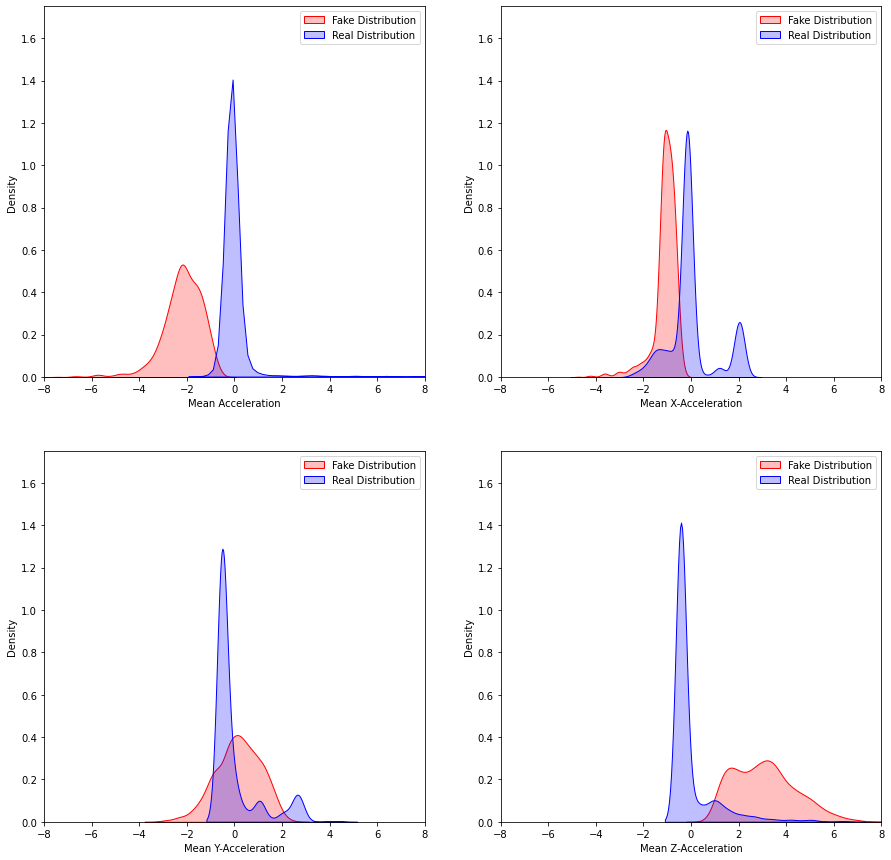

         7121259 function calls (7025419 primitive calls) in 14.107 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.069    0.069   14.107   14.107 <ipython-input-15-f48084b783bf>:52(training_loop)
      200    0.010    0.000    4.950    0.025 <ipython-input-10-82116bfce3c9>:6(all_Wasserstein_dists)
      400    0.004    0.000    4.489    0.011 C:\Users\jdeoliveira\anaconda3\lib\site-packages\torch\utils\data\dataloader.py:513(__next__)
      400    0.224    0.001    4.464    0.011 C:\Users\jdeoliveira\anaconda3\lib\site-packages\torch\utils\data\dataloader.py:555(_next_data)
      200    0.015    0.000    4.217    0.021 <ipython-input-10-82116bfce3c9>:12(<listcomp>)
     5200    0.021    0.000    4.203    0.001 C:\Users\jdeoliveira\anaconda3\lib\site-packages\scipy\stats\stats.py:7701(wasserstein_distance)
     5200    0.279    0.000    4.182    0.001 C:\Users\jdeoliveira\anaconda3\lib\site-packages\scipy\s

      400    0.002    0.000    0.010    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\core\internals\blocks.py:2662(get_block_type)
       16    0.000    0.000    0.010    0.001 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\core\generic.py:4159(_drop_axis)
       16    0.000    0.000    0.010    0.001 C:\Users\jdeoliveira\anaconda3\lib\site-packages\seaborn\_statistics.py:116(define_support)
      436    0.000    0.000    0.010    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\font_manager.py:713(_from_any)
       16    0.000    0.000    0.010    0.001 C:\Users\jdeoliveira\anaconda3\lib\site-packages\seaborn\_statistics.py:89(_define_support_univariate)
      184    0.002    0.000    0.010    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\axis.py:2244(get_tick_space)
     1120    0.001    0.000    0.010    0.000 <__array_function__ internals>:2(round_)
       32    0.000    0.000    0.01

        2    0.000    0.000    0.002    0.001 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\backend_bases.py:1530(_get_renderer)
      452    0.002    0.000    0.002    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\torch\autograd\grad_mode.py:114(__init__)
       86    0.000    0.000    0.002    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\axes\_base.py:750(get_xaxis_text2_transform)
      144    0.001    0.000    0.002    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\collections.py:303(_prepare_points)
     2078    0.001    0.000    0.002    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:244(iterable)
      224    0.000    0.000    0.002    0.000 <__array_function__ internals>:2(atleast_1d)
       64    0.000    0.000    0.002    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\collections.py:754(_set_facecolor)
      112    0.000    0.000    0.002    0

        4    0.000    0.000    0.001    0.000 C:\Users\jdeoliveira\anaconda3\lib\threading.py:270(wait)
     3824    0.001    0.000    0.001    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\font_manager.py:752(get_family)
     4296    0.001    0.000    0.001    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\text.py:852(get_text)
       16    0.000    0.000    0.001    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\core\generic.py:10715(max)
       32    0.000    0.000    0.001    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\spines.py:355(set_position)
      642    0.000    0.000    0.001    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\transforms.py:249(x0)
      522    0.000    0.000    0.001    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\lines.py:1218(set_markersize)
      528    0.000    0.000    0.001    0.000 C:\Users\jdeoliveira\AppData\Roaming\Py

       64    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\core\dtypes\dtypes.py:711(construct_from_string)
       34    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\figure.py:415(get_axes)
      416    0.000    0.000    0.000    0.000 {method 'get_width_height' of 'matplotlib.ft2font.FT2Font' objects}
       40    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\axis.py:1209(<listcomp>)
       96    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\core\internals\managers.py:991(_consolidate_inplace)
      600    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\axis.py:569(locator)
       48    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\core\generic.py:3408(_set_as_cached)

       16    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\offsetbox.py:735(add_artist)
        2    0.000    0.000    0.000    0.000 {built-in method builtins.dir}
       96    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexes\base.py:1232(name)
       52    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\inspect.py:72(isclass)
       64    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\seaborn\_core.py:41(__init__)
      112    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\pandas\core\internals\managers.py:173(blklocs)
       32    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\scipy\sparse\base.py:1205(isspmatrix)
      128    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\AppData\Roaming\Python\Python38\site-packages\p

        2    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\PIL\PngImagePlugin.py:1025(__init__)
        4    0.000    0.000    0.000    0.000 {method 'pixel_access' of 'ImagingCore' objects}
        8    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\PIL\Image.py:551(size)
        2    0.000    0.000    0.000    0.000 {method 'get' of 'mappingproxy' objects}
        2    0.000    0.000    0.000    0.000 {method 'splitlines' of 'str' objects}
        4    0.000    0.000    0.000    0.000 {built-in method _imp.lock_held}
        2    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\PIL\Image.py:336(preinit)
        2    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\matplotlib\backend_bases.py:1541(Done)
        1    0.000    0.000    0.000    0.000 C:\Users\jdeoliveira\anaconda3\lib\site-packages\torch\utils\data\dataloader.py:307(multiprocessing_con

In [19]:
#Load Data
model_output = None
print("Loading Data")
X, y = start_data("sample_data.csv", "label:SITTING")

#Set to true to see dynamic training, false for conventional training
conventional = False

#Profile runtime of GAN training
with cProfile.Profile() as pr:
    #Train
    training_loop(X,y, gan_id="gan_demo", batch_size = len(X), gen_lr=.005, disc_lr =.005, n_epochs=200, dig=4, constant_train_flag=conventional, disc_epochs = 5, gen_epochs = 2, save_models = False)
pr = pstats.Stats(pr).sort_stats('cumtime')
pr.print_stats()